In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing
from sklearn.utils import shuffle

## Forecasting

We will work with the weather dataset from Jena, Germany. It is provided by the Max Planck Institute and can be downloaded from Keras datasets.

In [2]:
tf.keras.utils.get_file('weather_data.zip',
                        'https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip',
                        cache_dir='./',
                        cache_subdir='datasets/weather',
                        extract=True)

13574144/13565642 [==============================] - 1s 0us/step


'./datasets/weather/weather_data.zip'

### Data exploration

In [3]:
# Import the data as a DataFrame for simple exploration.

df = pd.read_csv('./datasets/weather/jena_climate_2009_2016.csv')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000
mean,989.212508,9.448567,283.491182,4.954011,76.007045,13.575089,9.532524,4.042483,6.021630,9.638982,1216.069883,2.130309,3.532381,174.726164
std,8.359454,8.423685,8.504820,6.730411,16.477126,7.739481,4.183895,4.897270,2.655973,4.235130,39.977065,1.541830,2.340482,86.675965
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,0.000000,0.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.800000
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.480000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,14.630000,23.500000,360.000000


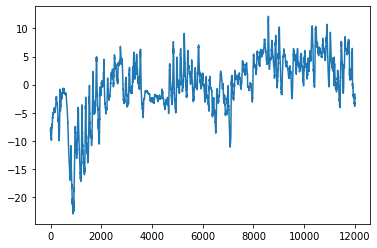

In [5]:
# We will focus on the temperature as the quantity of interest.

plt.plot(df['T (degC)'][:12000])

### Prepare datasets for a deep neural network model


In [6]:
# Let us separate the timestamps instead of which we can use the index.

df_timestamps = df['Date Time']
df = df.drop(columns='Date Time')

In [7]:
# Create a copy of the temperatur column which will act as our labels.

temps = df['T (degC)'].copy()

In [8]:
temps_mean = temps.mean()
temps_std = temps.std()

temps = (temps-temps_mean)/temps_std

In [9]:
# Normalize the data.

df = (df - df.mean())/df.std()

In [10]:
# Create time series datasets which package data in a sliding window.

# The number of samples included in our sliding window, analogous to the 
# kernel size in Convnets.
window_size = 120

# Analogous to strides in Convnets, the number of data points to skip when
# sampling data from the window.
strides = 6

# How far into the future is the target of prediction.
delay = strides * (window_size + 24 - 1)


# Choose how to split the datasets to training, validation and test datasets.
num_train = int(0.3 * len(df))
num_valid = int(0.2 * len(df))
num_test = len(df) - num_train - num_valid
batch_size = 256


train_dataset = keras.utils.timeseries_dataset_from_array(
    df[:-delay],
    targets=temps[delay:],
    sampling_rate=strides,
    sequence_length=window_size,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train)

valid_dataset = keras.utils.timeseries_dataset_from_array(
    df[:-delay],
    targets=temps[delay:],
    sampling_rate=strides,
    sequence_length=window_size,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train,
    end_index=num_train + num_valid)

test_dataset = keras.utils.timeseries_dataset_from_array(
    df[:-delay],
    targets=temps[delay:],
    sampling_rate=strides,
    sequence_length=window_size,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train + num_valid)

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### Baseline model

In [12]:
model_input = keras.Input(shape=(window_size, df.shape[-1]))
x = layers.Flatten()(model_input)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1)(x)
model_dense = keras.Model(model_input, x)

model_dense.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [13]:
model_dense.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten (Flatten)           (None, 1680)              0         
                                                                 
 dense (Dense)               (None, 16)                26896     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model_dense.fit(train_dataset,
                          epochs=4,
                          validation_data=valid_dataset)

Epoch 1/4
490/490 [==============================] - 18s 31ms/step - loss: 0.6440 - mae: 0.5725 - val_loss: 0.2101 - val_mae: 0.3577
Epoch 2/4
490/490 [==============================] - 16s 32ms/step - loss: 0.3153 - mae: 0.4321 - val_loss: 0.1960 - val_mae: 0.3461
Epoch 3/4
490/490 [==============================] - 16s 32ms/step - loss: 0.2964 - mae: 0.4179 - val_loss: 0.1873 - val_mae: 0.3356
Epoch 4/4
490/490 [==============================] - 15s 31ms/step - loss: 0.2868 - mae: 0.4108 - val_loss: 0.1869 - val_mae: 0.3345


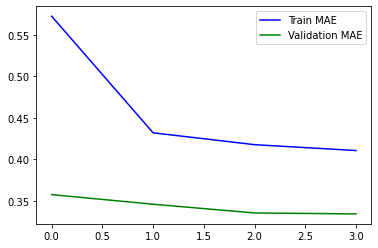

In [15]:
plt.plot(history.history['mae'], c='b')
plt.plot(history.history['val_mae'], c='g')
plt.legend(['Train MAE', 'Validation MAE'])
plt.show()

In [16]:
model_dense.evaluate(test_dataset)

816/816 [==============================] - 16s 19ms/step - loss: 0.1559 - mae: 0.3113


[0.155938059091568, 0.3113120198249817]

In [17]:
y_pred = np.zeros(shape=(0), dtype='float32')
y_true = np.zeros(shape=(0), dtype='float32')
for samples, targets in test_dataset:
    y_pred = np.concatenate([y_pred, model_dense.predict(samples).reshape((-1))], axis=0)
    y_true = np.concatenate([y_true, targets], axis=0)

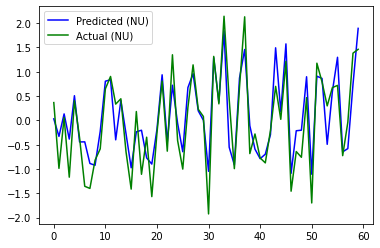

In [18]:
plt.plot(y_pred[:60], c='b')
plt.plot(y_true[:60], c='g')
plt.legend(['Predicted (NU)', 'Actual (NU)'])
plt.show()

### Convnet model

In [19]:
model_input = keras.Input(shape=(window_size, df.shape[-1]))
x = layers.Conv1D(16, 4, activation="relu")(model_input)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1)(x)

model_conv = keras.Model(model_input, x)

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=5,
                                         restore_best_weights=True)

model_conv.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [20]:
model_conv.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d (Conv1D)             (None, 117, 16)           912       
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_____________________________________________________________

In [21]:
history = model_conv.fit(train_dataset,
                         epochs=4,
                         validation_data=valid_dataset,
                         callbacks=callback)

Epoch 1/4
490/490 [==============================] - 24s 33ms/step - loss: 0.4352 - mae: 0.5185 - val_loss: 0.3523 - val_mae: 0.4643
Epoch 2/4
490/490 [==============================] - 16s 32ms/step - loss: 0.3961 - mae: 0.4975 - val_loss: 0.3588 - val_mae: 0.4667
Epoch 3/4
490/490 [==============================] - 16s 33ms/step - loss: 0.3924 - mae: 0.4948 - val_loss: 0.3592 - val_mae: 0.4667
Epoch 4/4
490/490 [==============================] - 16s 33ms/step - loss: 0.3908 - mae: 0.4930 - val_loss: 0.3541 - val_mae: 0.4644


In [22]:
model_conv.evaluate(test_dataset)

816/816 [==============================] - 16s 20ms/step - loss: 0.3137 - mae: 0.4380


[0.31367745995521545, 0.4379824101924896]

### Convnet with delayed input

In [23]:
model_input = keras.Input(shape=(window_size, df.shape[-1]))
x = layers.ZeroPadding1D(4)(model_input)
x = layers.Lambda(lambda x: x[:,:-8,:])(x)


# For timeseries it's important to ignore padding during training.
# We do that with the Masking layer.
x = layers.Masking()(x)

x = layers.Concatenate(axis=2)([model_input, x])
x = layers.Conv1D(16, 2, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1)(x)

model_conv_d = keras.Model(model_input, x)

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=5,
                                         restore_best_weights=True)

model_conv_d.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [24]:
model_conv_d.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 120, 14)]    0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 128, 14)     0           ['input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 120, 14)      0           ['zero_padding1d[0][0]']         
                                                                                                  
 masking (Masking)              (None, 120, 14)      0           ['lambda[0][0]']                 
                                                                                            

In [25]:
history = model_conv_d.fit(train_dataset,
                           epochs=4,
                           validation_data=valid_dataset,
                           callbacks=callback)

Epoch 1/4
490/490 [==============================] - 17s 33ms/step - loss: 1.0668 - mae: 0.7444 - val_loss: 0.3495 - val_mae: 0.4620
Epoch 2/4
490/490 [==============================] - 16s 33ms/step - loss: 0.3948 - mae: 0.4957 - val_loss: 0.3518 - val_mae: 0.4627
Epoch 3/4
490/490 [==============================] - 16s 32ms/step - loss: 0.3806 - mae: 0.4852 - val_loss: 0.3456 - val_mae: 0.4573
Epoch 4/4
490/490 [==============================] - 16s 32ms/step - loss: 0.3733 - mae: 0.4798 - val_loss: 0.3402 - val_mae: 0.4556


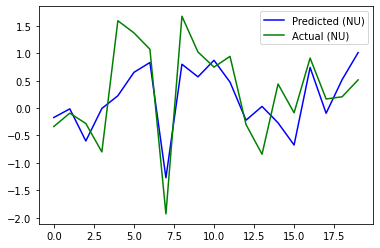

In [26]:
y_pred = np.zeros(shape=(0), dtype='float32')
y_true = np.zeros(shape=(0), dtype='float32')
for samples, targets in test_dataset:
    y_pred = np.concatenate([y_pred, model_conv_d.predict(samples).reshape((-1))], axis=0)
    y_true = np.concatenate([y_true, targets], axis=0)

plt.plot(y_pred[:20], c='b')
plt.plot(y_true[:20], c='g')
plt.legend(['Predicted (NU)', 'Actual (NU)'])
plt.show()

In [27]:
model_conv_d.evaluate(test_dataset)

816/816 [==============================] - 16s 20ms/step - loss: 0.3044 - mae: 0.4340


[0.30443301796913147, 0.4339759647846222]

## Simple RNN

In [28]:
model_input = keras.Input(shape=(window_size, df.shape[-1]))
x = layers.SimpleRNN(16, dropout=0.3, activation="relu")(model_input)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1)(x)

model_SRNN = keras.Model(model_input, x)

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=5,
                                         restore_best_weights=True)

model_SRNN.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [29]:
model_SRNN.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                496       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model_SRNN.fit(train_dataset,
                         epochs=4,
                         validation_data=valid_dataset,
                         callbacks=callback)

Epoch 1/4
490/490 [==============================] - 47s 93ms/step - loss: 1.2921 - mae: 0.7780 - val_loss: 0.2697 - val_mae: 0.4128
Epoch 2/4
490/490 [==============================] - 46s 93ms/step - loss: 0.4454 - mae: 0.5099 - val_loss: 0.2354 - val_mae: 0.3882
Epoch 3/4
490/490 [==============================] - 45s 92ms/step - loss: 0.3693 - mae: 0.4645 - val_loss: 0.2268 - val_mae: 0.3790
Epoch 4/4
490/490 [==============================] - 46s 93ms/step - loss: 0.3405 - mae: 0.4466 - val_loss: 0.2227 - val_mae: 0.3739


In [31]:
model_SRNN.evaluate(test_dataset)

816/816 [==============================] - 20s 24ms/step - loss: 0.1856 - mae: 0.3391


[0.18556144833564758, 0.33910995721817017]

### LSTM

In [32]:
model_input = keras.Input(shape=(window_size, df.shape[-1]))
x = layers.LSTM(8, dropout=0.4, activation="relu")(model_input)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1)(x)

model_LSTM = keras.Model(model_input, x)

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=5,
                                         restore_best_weights=True)

model_LSTM.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [33]:
model_LSTM.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 8)                 736       
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 745
Trainable params: 745
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model_LSTM.fit(train_dataset,
                         epochs=4,
                         validation_data=valid_dataset,
                         callbacks=callback)

Epoch 1/4
490/490 [==============================] - 88s 176ms/step - loss: 103066912.0000 - mae: 407.2011 - val_loss: 400802.0938 - val_mae: 181.5355
Epoch 2/4
490/490 [==============================] - 86s 175ms/step - loss: 952775.3750 - mae: 275.8606 - val_loss: 370278.7188 - val_mae: 173.3250
Epoch 3/4
490/490 [==============================] - 86s 176ms/step - loss: 855352.0625 - mae: 274.8587 - val_loss: 354583.0625 - val_mae: 178.2549
Epoch 4/4
490/490 [==============================] - 86s 176ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan


In [35]:
model_LSTM.evaluate(test_dataset)

816/816 [==============================] - 23s 28ms/step - loss: nan - mae: nan


[nan, nan]

### Stacked LSTMs

In [36]:
model_input = keras.Input(shape=(window_size, df.shape[-1]))
x = layers.LSTM(4, dropout=0.3, activation="relu", return_sequences=True)(model_input)
x = layers.LSTM(4, dropout=0.3, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1)(x)

model_LSTM2 = keras.Model(model_input, x)

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=5,
                                         restore_best_weights=True)

model_LSTM2.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [37]:
model_LSTM2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 120, 4)            304       
                                                                 
 lstm_2 (LSTM)               (None, 4)                 144       
                                                                 
 dropout_5 (Dropout)         (None, 4)                 0         
                                                                 
 dense_6 (Dense)             (None, 1)                 5         
                                                                 
Total params: 453
Trainable params: 453
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = model_LSTM2.fit(train_dataset,
                          epochs=4,
                          validation_data=valid_dataset,
                          callbacks=callback)

Epoch 1/4
490/490 [==============================] - 177s 356ms/step - loss: 0.6597 - mae: 0.6231 - val_loss: 0.4060 - val_mae: 0.5008
Epoch 2/4
490/490 [==============================] - 174s 355ms/step - loss: 0.5281 - mae: 0.5542 - val_loss: 0.4048 - val_mae: 0.4990
Epoch 3/4
490/490 [==============================] - 174s 355ms/step - loss: 0.5124 - mae: 0.5436 - val_loss: 0.4079 - val_mae: 0.4990
Epoch 4/4
490/490 [==============================] - 174s 356ms/step - loss: 0.5004 - mae: 0.5360 - val_loss: 0.4183 - val_mae: 0.5064


### Bi-directional LSTM

### Compare with GRU layers